In [1]:
import os
import datetime
import config as c
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.datasets import fetch_california_housing
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go

from visualization.utils import plot_correlation_matrix, plot_scatterplot_matrix
from utils.metrics import NIC
from utils.dataset import *
from utils.metrics import NIC
from sklearn.metrics import mean_squared_error
from utils.model import Model, get_combine_predictions

init_notebook_mode(connected=True)

warnings.filterwarnings('ignore')
plt.rcParams ['figure.figsize'] = (13,8)
sns.set()
%config InlineBackend.figure_format = 'retina'

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
df_trxn = load_trxn()
df_funnel, df_appl, df_aum, df_balance, df_client, df_com, df_deals, df_payments = get_dataset(True, True)

['feature_1_client_segment', 'top_value_appl_prod_group_name', 'top_value_appl_stts_name_dc', 'top_value_appl_sale_channel_name', 'gender', 'education', 'job_type']


# Создание фич

In [42]:
df_funnel.freq_feature_1_client_segment.astype("category").dtype.name

'category'

In [104]:
df_funnel.corr()[['sale_flg', 'sale_amount']].T

,client_id,sale_flg,sale_amount,contacts,feature_1,client_segment,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,region_cd,last_transaction_days_delta,month_payments,feature_10div7,freq_client_segment,freq_feature_1,freq_feature_9,feature_1_client_segment,freq_feature_1_client_segment,mean_balance,std_balance,appl_total_count,top_value_appl_prod_group_name,top_rate_appl_prod_group_name,top_value_appl_stts_name_dc,top_rate_appl_stts_name_dc,top_value_appl_sale_channel_name,top_rate_appl_sale_channel_name,appl_last_month,gender,age,education,job_type,region,city,agr_flg,otkaz,dumaet,ring_up_flg,not_ring_up_flg,count_comm,last_coll_days_delta,is_pensioner,salary_cards_agrmnt_sum_rur_mean,salary_cards_agrmnt_sum_rur_sum,credit_cards_agrmnt_rate_active,credit_cards_agrmnt_sum_rur,very_small_purchase,small_purchase,average_purchase,big_purchase,calls_number_in_recent_months,calls_number_in_recent_months,calls_number_in_recent_months,nonunique_tran_amt_rur,nonunique_mcc_cd,nonunique_tsp_name,hour,date
sale_flg,0.002857,1.0,NaN,0.026489,-0.038500,-0.301903,0.061878,0.023095,0.080969,0.124936,0.018460,0.146078,0.100573,-0.172643,0.132346,0.031089,-0.320021,0.018338,-0.123308,-0.164907,-0.025334,0.010514,-0.031458,-0.196077,-0.015676,0.013413,0.267512,0.231197,0.240348,0.145435,0.239223,-0.147496,0.271804,0.180856,-0.018891,-0.023022,0.151652,0.010433,-0.056472,-0.098920,0.169745,0.111194,0.121738,0.125542,-0.009069,0.077365,-0.088089,0.008870,-0.030281,-0.026449,0.048595,0.030189,0.080128,0.123916,0.142513,0.101865,-0.026127,0.006820,-0.026127,0.113415,0.134847,0.131751,-0.020476,0.138096
sale_amount,0.024852,NaN,1.0,-0.014242,-0.048497,-0.054515,0.153004,0.355598,0.443969,0.180681,0.369305,0.412839,0.323444,-0.152380,0.417258,0.170872,-0.004103,0.214024,-0.122544,-0.046127,-0.080837,-0.004636,-0.040862,-0.034348,0.151297,0.152457,0.141221,0.063069,0.048747,0.062730,0.101317,-0.107414,0.088075,0.026015,0.003237,0.094231,-0.158716,-0.005390,-0.146293,-0.104871,0.056251,0.029508,0.040437,0.040944,-0.017695,0.013811,-0.078283,0.040463,-0.003521,-0.004608,0.037871,0.015970,-0.027154,0.030592,0.145552,0.209729,-0.045056,-0.038939,-0.045056,0.015260,0.063427,0.050637,0.000033,0.005232


In [76]:
df = df_funnel.copy()

x = df[df['sale_amount'].fillna(0) > 0].drop(columns=['client_id', 'sale_flg', 'sale_amount', 'contacts']).to_numpy()
y = df[df['sale_amount'].fillna(0) > 0]['sale_amount'].to_numpy().reshape(-1, 1)

model_sale_amount = Model('model_sale_amount')
model_sale_amount.fit(x, y)
print(mean_squared_error(y, model_sale_amount.predict(x)))


x = df.drop(columns=['client_id', 'sale_flg', 'sale_amount', 'contacts']).to_numpy()
y = df['sale_flg'].to_numpy().reshape(-1, 1)

model_sale_flg = Model('model_sale_flg')
model_sale_flg.fit(x, y)
print(mean_squared_error(y, model_sale_flg.predict(x)))

x = df.drop(columns=['client_id', 'sale_flg', 'sale_amount', 'contacts']).to_numpy()

target = get_combine_predictions(x, model_sale_flg, model_sale_amount)
print('NIC:', NIC(target, df['sale_amount'], df['contacts']))

10it [00:09,  1.01it/s]
100%|██████████| 10/10 [00:00<00:00, 243.90it/s]
0it [00:00, ?it/s]

Models score: -439.485767126488
1045998813.0701977


10it [00:12,  1.22s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

Models score: -2768.9326240512137
0.08014756596302515


100%|██████████| 10/10 [00:00<00:00, 149.26it/s]

NIC: 5586.990838682668


In [519]:
df['target'] = target
#df['sale_amount_predict'] = model_sale_amount.predict(x)

In [563]:
df['target'] = model_sale_flg.predict(x)

100%|██████████| 10/10 [00:00<00:00, 169.90it/s]


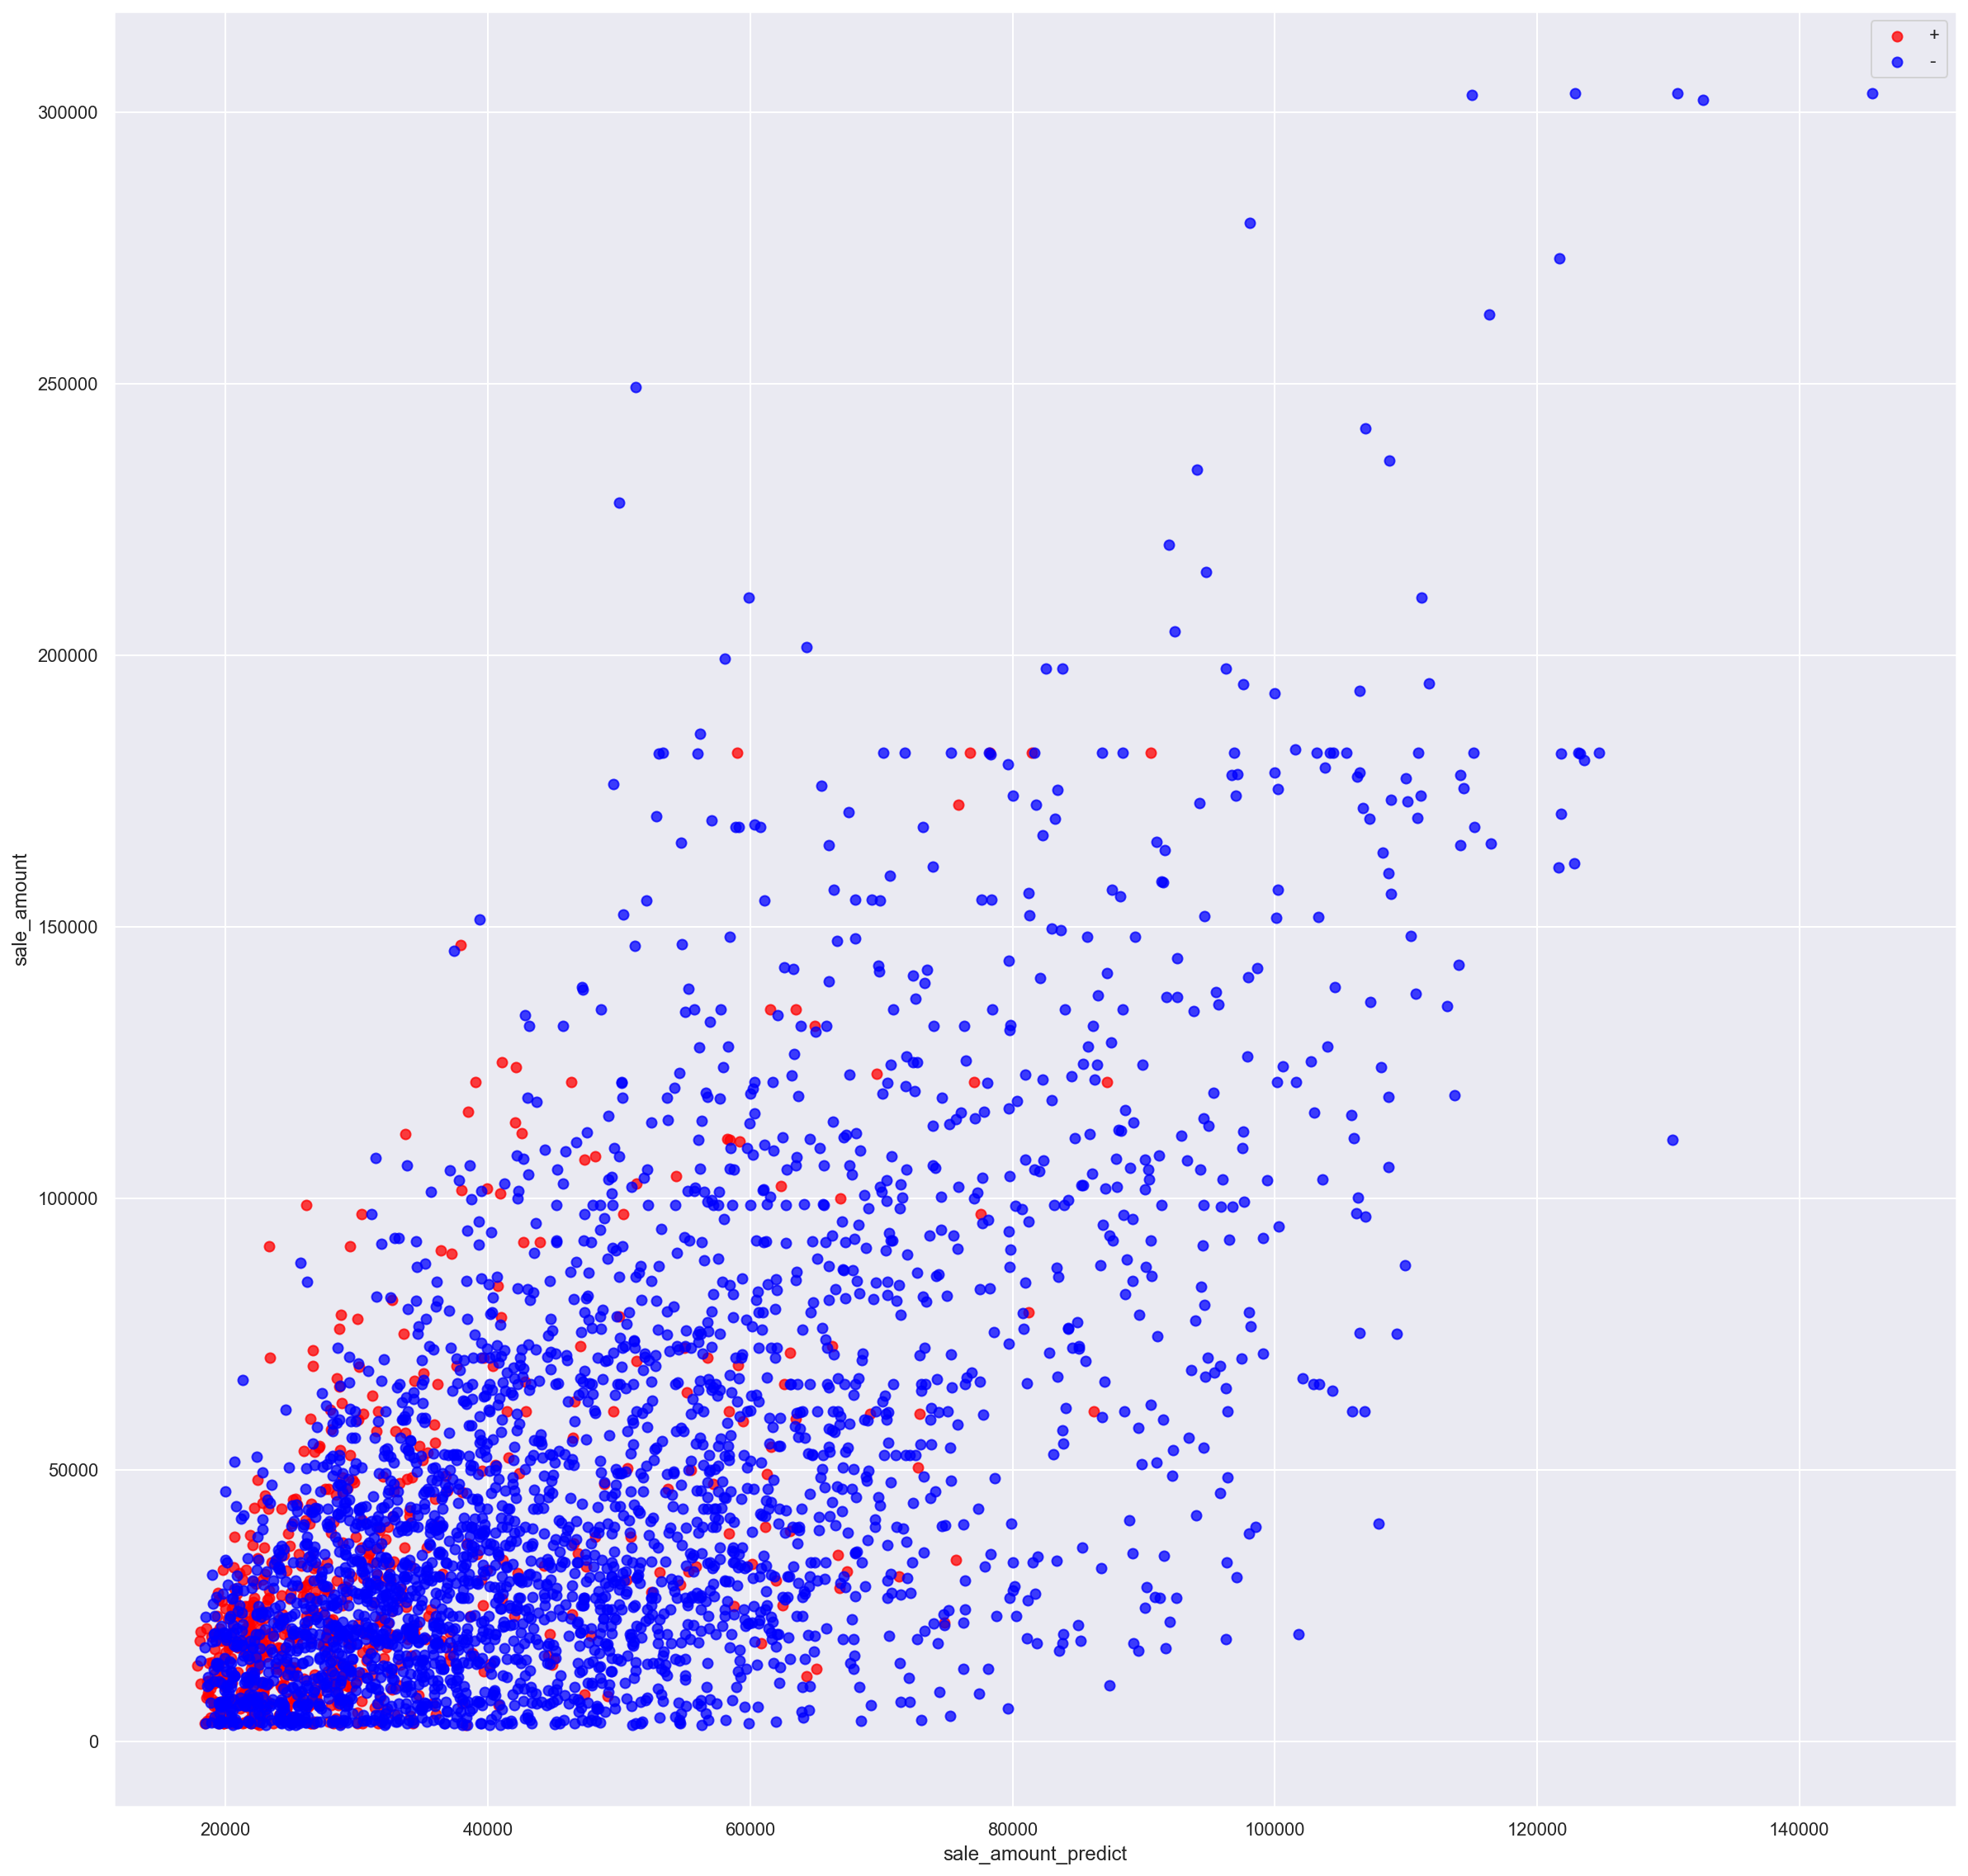

In [21]:
col1 = 'sale_amount_predict'
col2 = 'sale_amount'

plt.figure(figsize=(20, 20))

plt.scatter(df[col1][df['target'] == 0],
            df[col2][df['target'] == 0],
            alpha=0.75,
            color='red',
            label='+')

plt.scatter(df[col1][df['target'] == 1],
            df[col2][df['target'] == 1],
            alpha=0.75,
            color='blue',
            label='-')

plt.xlabel(col1)
plt.ylabel(col2)
plt.legend(loc='best');